In [1]:
import qtensor
import numpy as np
import torch

from circuit_11 import circuit_11, get_circ_and_peo

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
N = 8
FIXED = 4
LAYERS = 3

## Read eignestates

In [4]:
from pathlib import Path
def read_eigenstate(L=8, delta=0):
    data_path = Path(f'../data/XXZ_L{L}/')
    filename = f'XXZwave_{L}_{delta}.npy'
    return np.load(data_path/filename)

In [5]:
read_eigenstate(L=N).shape

(256, 1)

In [6]:
import qtree
class InitSim(qtensor.QtreeSimulator):
    def set_init_state(self, state):
        self.init_state = state

    def _create_buckets(self):
        self.tn = qtensor.optimisation.QtreeTensorNet.from_qtree_gates(
            self.all_gates, init_state=self.init_state, backend=self.backend,
        )
        self.tn.backend = self.backend

    def _get_slice_dict(self, initial_state=0, target_state=0):
        slice_dict = {}
        slice_dict.update(qtree.utils.slice_from_bits(target_state, self.tn.bra_vars))
        slice_dict.update(qtree.utils.slice_from_bits(target_state, self.tn.bra_vars))
        slice_dict.update({var: slice(None) for var in self.tn.free_vars})
        slice_dict.update({var: slice(None) for var in self.tn.ket_vars})
        return slice_dict

In [7]:
sim = InitSim(backend=qtensor.contraction_backends.get_backend('torch'))

In [8]:
data_size = 100
data_x = [
    read_eigenstate(L=N, delta=i) for i in range(data_size)
]
data_y = range(data_size)
data = list(zip(data_x, data_y))
train_size = 30
test_size = data_size - train_size
train_set, test_set = torch.utils.data.random_split(data, [train_size, test_size])

In [9]:
print(len(list(train_set)))

30


In [10]:
def amps2loss(amps):
    return -torch.abs(amps*torch.conj(amps)).sum()

In [11]:
def get_loss(sim, train_set):
    loss = torch.tensor(0.)
    for train_x, train_y in train_set:
        sim.set_init_state(train_x)
        amps = sim.simulate_batch(circ, peo=peo, batch_vars=range(FIXED, N))
        l = amps2loss(amps)
        loss += l
    loss /= len(train_set)
    return loss

In [12]:
parameters = torch.rand(LAYERS*(4*N - 4), requires_grad=True)
parameters.retain_grad()
parameters

tensor([0.2289, 0.3496, 0.7271, 0.7149, 0.8342, 0.4176, 0.4735, 0.1117, 0.2594,
        0.6042, 0.4455, 0.3762, 0.7943, 0.7951, 0.3287, 0.4822, 0.5964, 0.4802,
        0.7602, 0.4963, 0.7994, 0.9876, 0.5240, 0.8139, 0.6780, 0.0763, 0.7033,
        0.7128, 0.8461, 0.3976, 0.9221, 0.8038, 0.5167, 0.8323, 0.7140, 0.0406,
        0.7999, 0.6110, 0.1469, 0.5833, 0.7121, 0.6987, 0.0829, 0.1090, 0.4305,
        0.3398, 0.1190, 0.7401, 0.3519, 0.2481, 0.4396, 0.2859, 0.2091, 0.2843,
        0.1010, 0.2861, 0.5954, 0.2176, 0.6413, 0.7827, 0.0371, 0.9888, 0.2293,
        0.6932, 0.8355, 0.6527, 0.1874, 0.3500, 0.5401, 0.5786, 0.6829, 0.2474,
        0.1420, 0.0825, 0.0348, 0.2037, 0.9243, 0.5596, 0.7120, 0.0866, 0.6934,
        0.9977, 0.1747, 0.7645], requires_grad=True)

In [13]:
lr = 0.05

In [14]:
optimizer = torch.optim.Adam([parameters], lr=lr)

In [15]:
steps = 150
stop_epsilon = 1e-4

In [16]:
loss_prev = np.inf

peo, circ = get_circ_and_peo(parameters, N=N, layers=LAYERS, fixed=FIXED)
for i in range(steps):
    
    loss = get_loss(sim, train_set)
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'[{i}] loss=', loss.data, 'sum_grad=', np.abs(parameters.grad.detach().numpy().sum()))
    
    if abs((loss_prev - loss.data.numpy())/loss.data) < stop_epsilon:
        print(f'Reached convergence after {i} steps!')
        break
    #print(amps.data, np.abs(np.square(amps.detach().numpy())))
    loss_prev = loss.data
    parameters.grad.zero_()
    

[0] loss= tensor(-0.0435) sum_grad= 0.08164843
[1] loss= tensor(-0.1413) sum_grad= 0.41639248
[2] loss= tensor(-0.2186) sum_grad= 0.65833634
[3] loss= tensor(-0.2887) sum_grad= 0.8252453
[4] loss= tensor(-0.3744) sum_grad= 0.92457104
[5] loss= tensor(-0.4392) sum_grad= 0.82534873
[6] loss= tensor(-0.4933) sum_grad= 0.54441255
[7] loss= tensor(-0.5458) sum_grad= 0.32363868
[8] loss= tensor(-0.5673) sum_grad= 0.31147036
[9] loss= tensor(-0.5665) sum_grad= 0.2970045
[10] loss= tensor(-0.5630) sum_grad= 0.09090128
[11] loss= tensor(-0.5667) sum_grad= 0.6034227
[12] loss= tensor(-0.5717) sum_grad= 0.7832838
[13] loss= tensor(-0.5792) sum_grad= 0.56303704
[14] loss= tensor(-0.5990) sum_grad= 0.119745955
[15] loss= tensor(-0.6264) sum_grad= 0.40425223
[16] loss= tensor(-0.6473) sum_grad= 0.84443754
[17] loss= tensor(-0.6674) sum_grad= 0.9801605
[18] loss= tensor(-0.6861) sum_grad= 0.7273859
[19] loss= tensor(-0.6986) sum_grad= 0.33211693
[20] loss= tensor(-0.7088) sum_grad= 0.017565023
[21] l

In [25]:
len(parameters)/3

28.0

## Test results

In [26]:
import matplotlib.pyplot as plt


In [27]:
def get_compression(delta):
    """
    Returns:
        original_state, compressed_state
    """
    test_sim = InitSim()
    #test_sim = qtensor.QtreeSimulator()
    state = read_eigenstate(L=N, delta=delta)
    test_sim.set_init_state(state)
    params = parameters.detach().numpy()
    peo, circ = get_circ_and_peo(parameters.detach().numpy(), N=N,
                                 layers=LAYERS, fixed=0, backend='numpy',
                                )
    amps_np = test_sim.simulate_batch(circ, peo=peo, batch_vars=N)
    return state.flatten(), amps_np
    

In [28]:
def compare_compression(orig_state, compressed_state):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    plt.sca(axs[0])
    plot_state(orig_state)
    plt.sca(axs[1])
    plot_state(compressed_state)
    

In [29]:
def plot_state(state):
    probs = np.abs(state*state).flatten()
    plt.bar(range(len(probs)), probs)

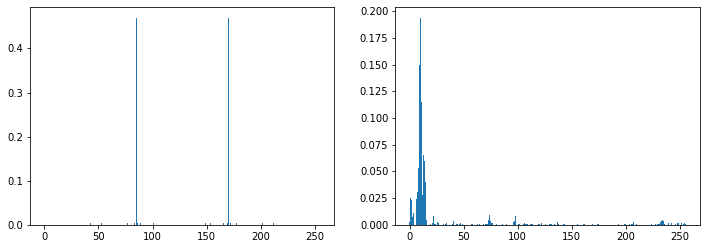

In [30]:
compression = get_compression(delta=10)
compare_compression(*compression)

### Look at more test

In [32]:
compressions = [get_compression(delta=i) for i in range(len(train_set))[:5]]    

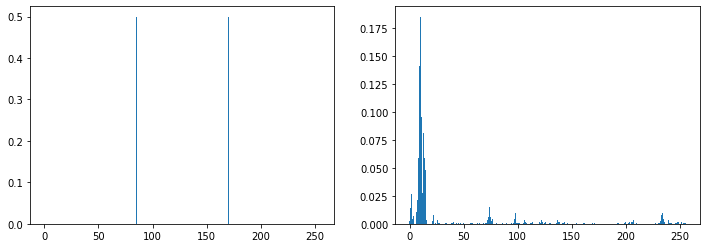

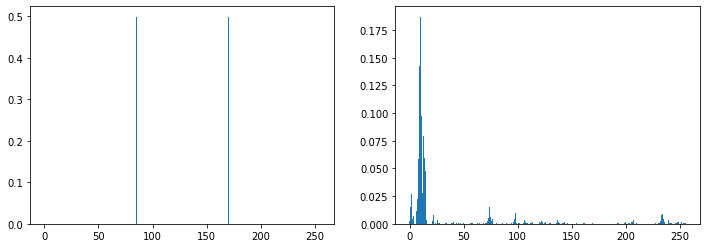

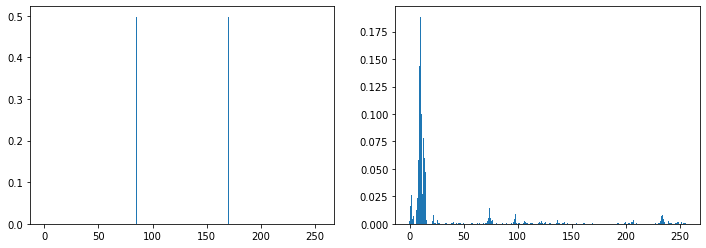

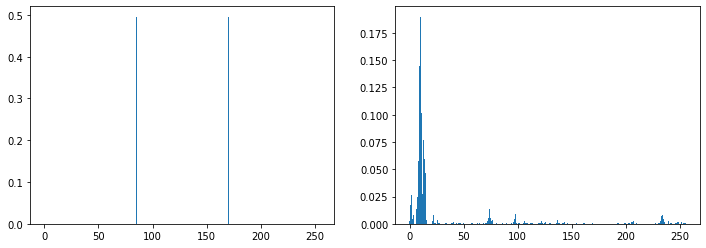

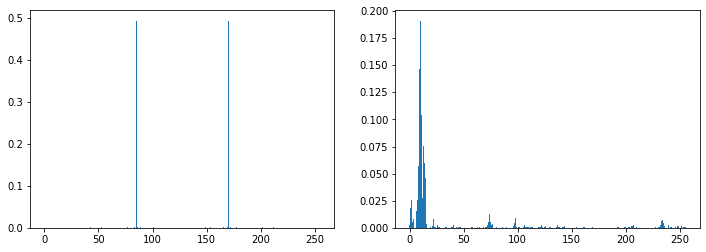

In [33]:
_ = [compare_compression(*i) for i in compressions]

In [ ]:
compressed

## Plot fidelity susceptibility

In [1]:
from cartesian_explorer import Explorer
from cartesian_explorer.caches import JobLibCache
cache = JobLibCache('../data/caex_cache/fsup')
ex = Explorer(cache=cache)

In [2]:
@ex.provider
def eigenstate(L, delta):
    data_path = Path(f'../data/XXZ_L{L}/')
    filename = f'XXZwave_{L}_{delta}.npy'
    return np.load(data_path/filename).flatten()

@ex.provider
def eigenstate_delta(L, delta):
    data_path = Path(f'../data/XXZ_L{L}/')
    filename = f'XXZwavedeltadelta_{L}_{delta}.npy'
    return np.load(data_path/filename).flatten()

In [3]:
def encode_state(state, parameters):
    test_sim = InitSim()
    #test_sim = qtensor.QtreeSimulator()
    test_sim.set_init_state(state)
    peo, circ = get_circ_and_peo(parameters, N=N,
                                 layers=LAYERS, fixed=0, backend='numpy',
                                )
    amps_np = test_sim.simulate_batch(circ, peo=peo, batch_vars=N)
    return amps_np


In [4]:
@ex.provider
def encoded(eigenstate, parameters):
    return encode_state(eigenstate, parameters)
    
@ex.provider
def encoded_delta(eigenstate_delta, parameters):
    return encode_state(eigenstate_delta, parameters)
    

In [5]:
@ex.provider
def fsup_original(eigenstate, eigenstate_delta):
    return np.abs(np.dot(eigenstate.conj(), eigenstate_delta))
    
@ex.provider
def fsup_encoded(encoded, encoded_delta):
    return np.abs(np.dot(encoded.conj(), encoded_delta))

@ex.provider
def fsup_encoded_traced(encoded, encoded_delta):
    pseudo_trace = lambda x: x.reshape(*[2]*N).sum(axis=tuple(range(FIXED))).flatten()
    a, b = pseudo_trace(encoded), pseudo_trace(encoded_delta)
    return np.abs(np.dot(a.conj(), b))

@ex.provider
def fsup_encoded_sliced(encoded, encoded_delta):
    a, b = encoded[:2**FIXED], encoded_delta[:2**FIXED]
    return np.abs(np.dot(a.conj(), b))

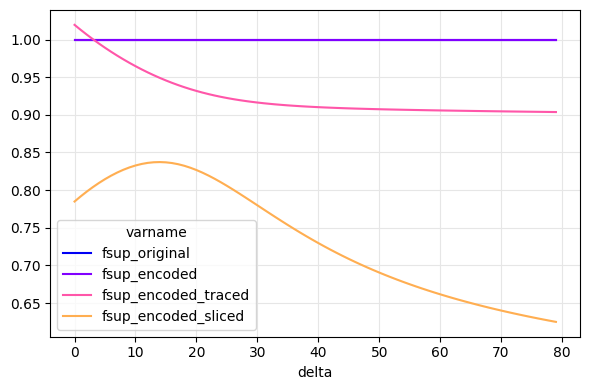

In [66]:
fig = ex.plot_variables(('fsup_original', 'fsup_encoded', 'fsup_encoded_traced', 'fsup_encoded_sliced'),
                        L=[8],
                        delta=range(80),
                        parameters=[parameters.detach().numpy()]
                 ),

In [6]:
from collections import defaultdict

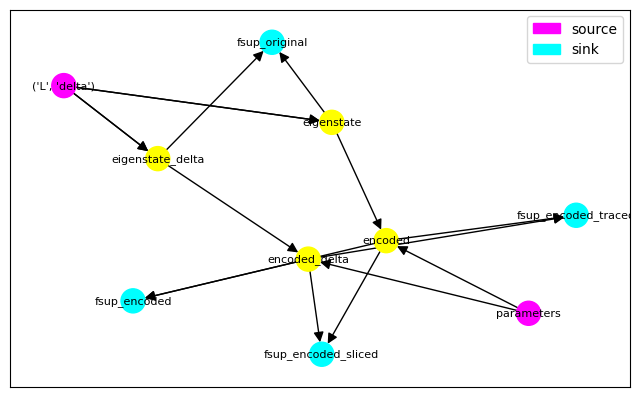

In [8]:
fig = ex.draw_dependency_graph(edge_labels=defaultdict(lambda x: ''))